In [3]:
# Common imports
import os
import sys
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import yaml

# Torch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Ultralytics YOLO for loading YOLOv11
!pip install ultralytics
from ultralytics import YOLO

In [5]:
#Define the Dataset Class for IP102
class IP102Dataset(Dataset):
    """A dataset class for the IP102 dataset in YOLO format."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with images and labels (e.g., /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train).
            transform (callable, optional): Optional data augmentation to be applied on a sample.
        """
        self.data_dir = Path(data_dir)
        self.image_list = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = str(self.data_dir / img_name)
        label_path = str(self.data_dir.parent.parent / 'labels' / self.data_dir.name / (img_name.replace('.jpg', '.txt')))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        else:
            boxes = []

        # Parse boxes
        bboxes = []
        labels = []
        for box in boxes:
            class_id, center_x, center_y, width, height = box
            # Convert YOLO format (normalized) to Pascal VOC format (absolute coordinates)
            img_height, img_width = img.shape[:2]
            xmin = (center_x - width / 2) * img_width
            ymin = (center_y - height / 2) * img_height
            xmax = (center_x + width / 2) * img_width
            ymax = (center_y + height / 2) * img_height
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        if self.transform:
            transformed = self.transform(image=img, bboxes=bboxes, class_labels=labels)
            img = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            bboxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)

        return img, bboxes, labels

In [6]:
# Define Data Augmentation
transform = A.Compose([
    A.LongestMaxSize(416, p=1),
    A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=20))

/tmp/ipykernel_100/3553826755.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),


In [7]:
# Set Up the Dataset and DataLoader
train_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
val_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

train_dataset = IP102Dataset(train_data_dir, transform=transform)
val_dataset = IP102Dataset(val_data_dir, transform=transform)

def collate_fn(batch):
    images, bboxes, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

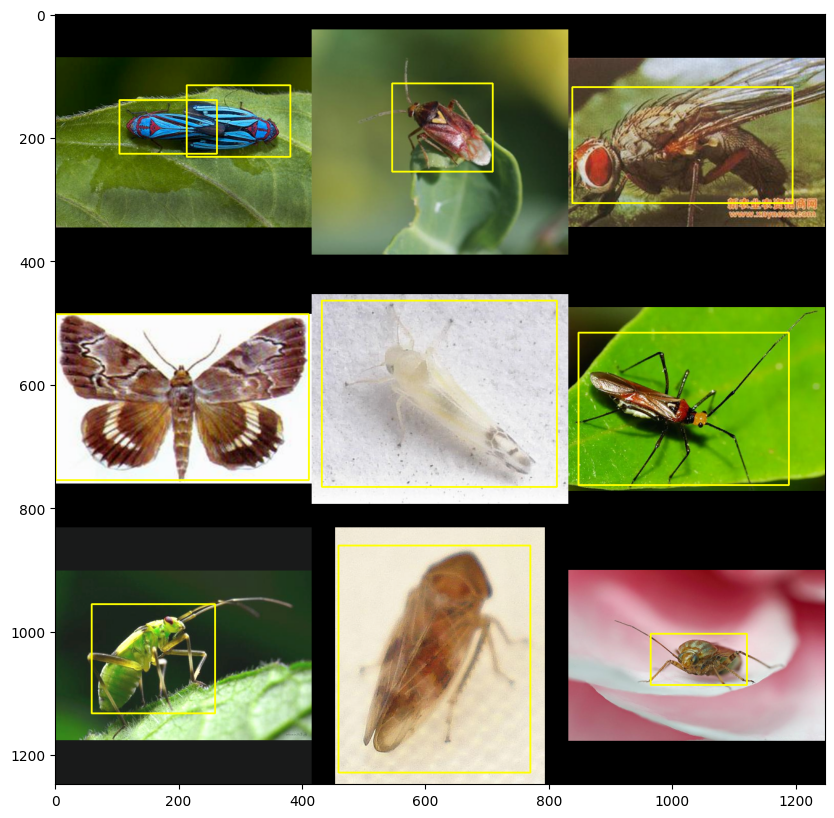

In [8]:
# Sanity Check of the Dataset
hlines = []
for i in range(3):
    vlines = []
    for j in range(3):
        idx = random.randint(0, len(train_dataset) - 1)
        img, bboxes, labels = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = (img * 255).astype(np.uint8)

        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        vlines.append(img)
    hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(final_img)
plt.show()

In [9]:
# Load Pre-trained YOLOv8 Model
model = YOLO("/kaggle/input/yolo11/pytorch/default/1/yolo11x.pt")

In [10]:
# Copy the original ip102.yaml to the working directory and modify the paths
original_yaml_path = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/ip102.yaml"
new_yaml_path = "/kaggle/working/ip102_corrected.yaml"

# Read the original YAML file
with open(original_yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)

# Update the paths to the correct absolute paths
yaml_content['train'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
yaml_content['val'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

# Save the modified YAML file
with open(new_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Modified ip102.yaml saved to {new_yaml_path}")
print("Updated paths:")
print(f"train: {yaml_content['train']}")
print(f"val: {yaml_content['val']}")

Modified ip102.yaml saved to /kaggle/working/ip102_corrected.yaml
Updated paths:
train: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train
val: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val


In [11]:
# Train the Model Using Ultralytics YOLO API
# The Ultralytics YOLO implementation simplifies training by handling the loss function and training loop internally.
# We just need to provide the dataset configuration and training parameters.

# Train the model
results = model.train(
    data=new_yaml_path,
    epochs=50,
    imgsz=416,
    batch=16,
    warmup_epochs=5,
    device=0,
    patience=15,
    save=True,
    project="/kaggle/working/yolo_training",
    name="ip102_yolov11x",
    cos_lr=True,
    lr0=0.001,
    augment=True,
    verbose=True
)

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/ip102_corrected.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo11/pytorch/default/1/yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ip102_yolov11x2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

train: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [01:52<00:00, 156.59it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3.1±2.2 MB/s, size: 25.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:08<00:00, 157.93it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/yolo_training/ip102_yolov11x2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_training/ip102_yolov11x2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.32G      1.443      3.006      1.691         55        416: 100%|██████████| 1103/1103 [14:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       1329       1621      0.585       0.31      0.306      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.37G      1.351      2.067      1.598         40        416: 100%|██████████| 1103/1103 [13:56<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]

                   all       1329       1621      0.527      0.334      0.313       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.31G      1.382      2.094      1.635         45        416: 100%|██████████| 1103/1103 [13:52<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.628      0.289      0.311      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.49G      1.412      2.237      1.669         36        416: 100%|██████████| 1103/1103 [13:48<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.538      0.269      0.238       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.35G      1.452      2.398      1.687         43        416: 100%|██████████| 1103/1103 [13:45<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.502      0.284      0.267      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.52G      1.467       2.44      1.693         37        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.517      0.334      0.274      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.55G      1.425       2.27      1.651         37        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]

                   all       1329       1621      0.526      0.354       0.33      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.33G      1.391      2.117      1.628         47        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.485      0.391      0.382      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.34G      1.374      2.012      1.607         52        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.506      0.415      0.391      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.36G      1.353      1.927      1.592         45        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.567      0.412      0.451       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.55G      1.341      1.881       1.58         48        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621       0.51      0.457      0.445      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.5G      1.318      1.821      1.566         42        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.495      0.487      0.464      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.49G      1.307      1.752      1.548         26        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621       0.39      0.556       0.49      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.52G      1.297      1.711      1.543         40        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.517      0.532      0.502      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.55G      1.292      1.674      1.533         35        416: 100%|██████████| 1103/1103 [13:46<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.563      0.484      0.536      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.51G      1.286      1.632      1.531         35        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.495      0.574      0.549      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       7.5G      1.269      1.587      1.516         40        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.526      0.578      0.554      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.53G      1.263      1.555      1.506         37        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.538      0.554      0.565      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.39G       1.25      1.516      1.498         32        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.477      0.592      0.583      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.34G      1.248      1.479      1.496         39        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621       0.52      0.578      0.576      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       7.5G      1.231      1.445      1.479         36        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621       0.55      0.586      0.594      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.52G      1.229      1.425      1.476         38        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.452      0.587      0.575      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.55G      1.222      1.397      1.472         48        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621       0.53      0.595      0.593       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.36G       1.21      1.363      1.459         34        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.635      0.583      0.621      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.5G      1.201      1.344      1.457         43        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.517      0.642      0.627      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.53G      1.195        1.3      1.449         38        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621       0.53       0.61       0.63      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.56G      1.183      1.293      1.445         40        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.602      0.587      0.634      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       7.5G      1.179      1.268      1.439         36        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.602      0.592      0.637      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.5G      1.169      1.244       1.43         42        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.562      0.619      0.636      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.34G      1.161      1.212      1.428         72        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.557      0.644      0.651      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.39G      1.152      1.185      1.416         43        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621       0.54      0.658      0.648      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.51G      1.142      1.163      1.412         35        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621       0.57      0.622      0.652      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       7.5G      1.131      1.145      1.406         47        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]

                   all       1329       1621      0.551      0.642      0.651      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.53G      1.126      1.118      1.401         39        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.581      0.623      0.659      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.39G      1.112      1.089      1.387         42        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.618      0.607      0.656      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       7.5G      1.106      1.074      1.388         41        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.556      0.653       0.66      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.5G      1.096      1.044      1.383         35        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.569      0.649      0.665      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.53G      1.091      1.032      1.378         42        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.611      0.638      0.671      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.55G      1.079      1.013       1.37         47        416: 100%|██████████| 1103/1103 [13:45<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.653      0.605      0.663      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       7.5G      1.071     0.9919      1.362         34        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.649      0.609      0.663      0.436


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       7.5G      1.006      0.707      1.439         15        416: 100%|██████████| 1103/1103 [13:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.544      0.653      0.659      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.35G     0.9872     0.6736      1.423         15        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.538      0.648      0.657      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.56G     0.9696     0.6552      1.414         14        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]

                   all       1329       1621      0.536       0.65       0.66      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       7.5G     0.9572      0.644      1.402         16        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.564      0.634      0.655      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.5G     0.9433     0.6235      1.394         14        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

                   all       1329       1621      0.563      0.628      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.53G     0.9342     0.6141      1.386         24        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621       0.54      0.673      0.661       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.57G     0.9275     0.6028       1.38         19        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.537      0.675      0.665      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.5G     0.9231     0.5991      1.376         40        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.537      0.681      0.667      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.49G     0.9169     0.5948      1.373         14        416: 100%|██████████| 1103/1103 [13:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]

                   all       1329       1621      0.537      0.676       0.67      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.34G     0.9155     0.5899      1.369         14        416: 100%|██████████| 1103/1103 [13:42<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]

                   all       1329       1621      0.539      0.671      0.667      0.432



50 epochs completed in 11.742 hours.
Optimizer stripped from /kaggle/working/yolo_training/ip102_yolov11x2/weights/last.pt, 114.6MB
Optimizer stripped from /kaggle/working/yolo_training/ip102_yolov11x2/weights/best.pt, 114.6MB

Validating /kaggle/working/yolo_training/ip102_yolov11x2/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 190 layers, 56,944,834 parameters, 0 gradients, 195.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621       0.61      0.648      0.683      0.452
      rice leaf roller         12         13      0.774          1       0.99      0.723
 rice leaf caterpillar          8          8       0.18      0.125      0.186       0.12
     paddy stem maggot          2          2          1          0      0.448      0.234
    asiatic rice borer         12         13      0.617      0.769      0.686      0.422
     yellow rice borer          6          6      0.697      0.771       0.87      0.556
       rice gall midge          7          7      0.874      0.994      0.978      0.494
          Rice Stemfly          2          2       0.65        0.5      0.695      0.398
    brown plant hopper          8          8      0.615      0.375      0.583      0.378
white backed plant hopper          5          5       0.65          1      0.962      0.686
small brown plant hopper          4          4      0.759        0.5      0.731      0.366
     rice water 

In [12]:
# Evaluate on Validation Set
val_results = model.val(data=new_yaml_path, split="val")
print(f"Validation mAP@0.5: {val_results.box.map50:.4f}")
print(f"Validation mAP@0.5:0.95: {val_results.box.map:.4f}")

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 190 layers, 56,944,834 parameters, 0 gradients, 195.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.0±9.4 MB/s, size: 19.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:04<00:00, 319.30it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621      0.621      0.642      0.677       0.45
      rice leaf roller         12         13      0.735          1      0.968        0.7
 rice leaf caterpillar          8          8      0.333       0.25       0.21      0.141
     paddy stem maggot          2          2          1          0      0.448      0.234
    asiatic rice borer         12         13      0.624      0.766      0.686      0.422
     yellow rice borer          6          6       0.69      0.747       0.87      0.555
       rice gall midge          7          7      0.874       0.99      0.978      0.494
          Rice Stemfly          2          2      0.655        0.5      0.695      0.397
    brown plant hopper          8          8      0.617      0.375      0.596      0.386
white backed plant hopper          5          5      0.652          1      0.962      0.686
small brown plant hopper          4          4      0.766        0.5       0.72      0.358
     rice water 

In [13]:
# Export for Mobile Deployment
# Export to ONNX
model.export(format="onnx", imgsz=416)

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/yolo_training/ip102_yolov11x2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 106, 3549) (109.3 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 11.2s, saved as '/kaggle/working/yolo_training/ip102_yolov11x2/weights/best.onnx' (217.5 MB)

Export complete (12.9s)
Results saved to /kaggle/working/yolo_training/ip102_yolov11x2/weights
Predict:         yolo predict task=detect model=/kaggle/working/

'/kaggle/working/yolo_training/ip102_yolov11x2/weights/best.onnx'

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import yaml
import os

# Step 1: Load the Class Names from ip102.yaml
yaml_path = "/kaggle/working/ip102_corrected.yaml"
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
class_names = yaml_content['names']  # List of 102 pest class names

# Step 2: Load the Trained YOLOv11 Model
model_weights_path = "/kaggle/working/yolo_training/ip102_yolov11x2/weights/best.pt"
model = YOLO(model_weights_path)
print(f"Loaded trained YOLOv11 model from {model_weights_path}")

# Step 3: Define the Directory of Unseen Test Images
test_images_dir = "/kaggle/input/pest-test-images/"  # Directory containing test images
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Step 4: Perform Inference on Each Test Image
for image_file in image_files:
    unseen_image_path = os.path.join(test_images_dir, image_file)
    img = cv2.imread(unseen_image_path)
    if img is None:
        print(f"Could not load image from {unseen_image_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_height, img_width = img.shape[:2]
    print(f"Processing image: {image_file} ({img_width}x{img_height})")

    # Run inference with a lower confidence threshold
    results = model.predict(
        source=unseen_image_path,
        conf=0.1,  # Lower confidence threshold
        iou=0.7,   # IoU threshold for NMS
        imgsz=416, # Match training image size
        device=0,  # Use GPU
        verbose=False
    )
    result = results[0]

    # Extract bounding boxes, class IDs, and confidence scores
    boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else np.array([])
    confidences = result.boxes.conf.cpu().numpy() if result.boxes else np.array([])
    class_ids = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else np.array([])

    # Draw bounding boxes and labels on the image
    if len(boxes) > 0:
        for box, conf, class_id in zip(boxes, confidences, class_ids):
            xmin, ymin, xmax, ymax = map(int, box)
            label = class_names[class_id]
            confidence = conf

            # Draw the bounding box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Add label with class name and confidence
            label_text = f"{label}: {confidence:.2f}"
            cv2.putText(img, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"No detections for {image_file} with confidence threshold 0.1")

    # Step 5: Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Unseen Image: {image_file}")
    plt.show()

    # Step 6: Print Detection Results
    print(f"\nDetection Results for {image_file} (Confidence Threshold 0.1):")
    if len(boxes) > 0:
        for box, conf, class_id in zip(boxes, confidences, class_ids):
            print(f"Class: {class_names[class_id]}, Confidence: {conf:.2f}, Box: [xmin={box[0]:.0f}, ymin={box[1]:.0f}, xmax={box[2]:.0f}, ymax={box[3]:.0f}]")
    else:
        print("No detections found. Consider lowering the confidence threshold or retraining the model.")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/yolo_training/ip102_yolov11x/weights/best.pt'